# Analyze A/B Test Results 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Taking date and time into account](#date)
- [Conclusion](#conclusion)
- [Recources used](#resources)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

In [79]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [80]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [81]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [82]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [83]:
df['converted'].sum()/df.shape[0]

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [84]:
ambiguous_rows = df.query('(group == "treatment" & landing_page != "new_page") | (group == "control" & landing_page != "old_page")')
ambiguous_rows['user_id'].count()

3893

**f.** Do any of the rows have missing values?

In [85]:
df.isna().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

### ToDo 1.2  

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

In [86]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(ambiguous_rows.index)
df2.shape

(290585, 5)

In [87]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  

**a.** How many unique **user_id**s are in **df2**?

In [88]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [89]:
df2[df2.duplicated('user_id')].user_id

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [90]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [91]:
# Remove one of the rows with a duplicate user_id..
df2.drop(2893, inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


### ToDo 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [92]:
p_pop = df2['converted'].mean()
p_pop

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [93]:
ctrl_crt = df2.query('group == "control"')['converted'].mean()
ctrl_crt

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [94]:
trt_crt = df2.query('group == "treatment"')['converted'].mean()
trt_crt

0.11880806551510564

In [95]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = trt_crt - ctrl_crt
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [96]:
df2.query('landing_page == "new_page"').count()/df2.shape[0]

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.  

**Answer:**  
**The observed conversion rate for the treatment group is 0.16% lower than for the control group, so the new page did not lead to more conversions.**

<a id='ab_test'></a>
## Part II - A/B Test

### ToDo 2.1
If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

>**Put your answer here.**  
**$H_0$**: **$p_{old}$** >= **$p_{new}$**  
**$H_1$**: **$p_{old}$** < **$p_{new}$**

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [97]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [98]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? 

In [99]:
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [100]:
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  

In [101]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice(2, size=n_new, p=[1 - p_new, p_new])
new_page_converted[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis.

In [102]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice(2, size=n_old, p=[1 - p_old, p_old])
old_page_converted[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [103]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.0022416761216669384


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

In [104]:
# Sampling distribution 
p_new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
p_old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = p_new_page_converted - p_old_page_converted

In [105]:
#convert list to numpy array
p_diffs = np.array(p_diffs)

**i. Histogram**<br> 

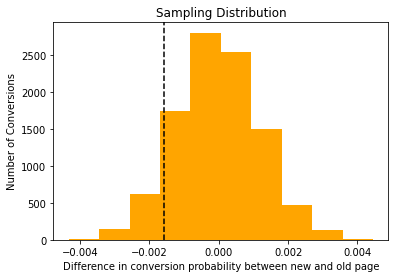

In [106]:
plt.hist(p_diffs, color='orange')
plt.title('Sampling Distribution')
plt.xlabel('Difference in conversion probability between new and old page')
plt.ylabel('Number of Conversions')
plt.axvline(x=obs_diff, color='k', linestyle='--');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [107]:
#compute p-value
(p_diffs > obs_diff).mean()

0.9062

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages?   

**Answer:**   
**It's called a p-value, which is the probability of a test statistic value as extreme or more extreme than the observed value.**  
**If the p-value is equal to or smaller than the type I error rate, there is evidence that the null hypothesis can be rejected. Otherwise (like in this case: 0.9 > 0.05) we fail to reject the null hypothesis.**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [108]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page" and converted == 1')['user_id'].count()
print(convert_old)
# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page" and converted == 1')['user_id'].count()
print(convert_new)

17489
17264


In [109]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score)
print(p_value)

-1.3109241984234394
0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:**  
**The p-value is the same as before (0.905), which confirms the findings from before.  
$Z_{0.05}$ = 1.645  
$Z_{score}$ = -1.3  
$Z_{score}$ < $Z_{\alpha}$.  
Since it was a right-tailed test, this means that we fail to reject the null hypothesis, which stated that the conversion rate of the old page is equal to or higher than that of the new page.**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:**  
**Logistic Regression**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [110]:
#add column for intercept
df2['intercept'] = 1

In [111]:
#add dummy column for group
dummies = pd.get_dummies(df2['group'])
df2['ab_page'] = dummies['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [112]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
res = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [113]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-06-05 18:20 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [114]:
#get odds ratios
np.exp(res.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

**e.** 
- What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?    
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?  
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 

**Answer:**  
**The p-value is 0.19. It is higher than the Type I error rate of 0.05, which indicates, that the null hypothesis cannot be rejected.**

**The estimated coefficients are the log odds. By exponentiating these values we get the odds ratios:   
the odds ratio for ab_page is 0.985, which is less than 1, which indicates that conversion is slightly less likely with the treatment.**

**In logistic regression, two hypotheses are of interest: the null hypothesis, which is when all the coefficients take the value zero and the alternative hypothesis, that the model differs significantly from the null or zero. 
That means, that it is a two-sided test in Part III, while in Part II a one-sided test was done. This explains the difference between the two p-values.**

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**  
**Additional variables can help to prevent bias by adding complexity. Looking at just one variable might lead to underfitting.
A disadvantage when adding many additional terms is, that it could lead to overfitting by increasing the complexity of the model. Regularization can be used as a counter measure to overfitting.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

In [115]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')

In [116]:
# Join with the df2 dataframe
df_merged = df2.merge(countries, on='user_id', how='left')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [117]:
#proportions of users from different countries
df_merged.groupby('country')['user_id'].count()/df_merged.shape[0]

country
CA    0.049896
UK    0.249381
US    0.700723
Name: user_id, dtype: float64

In [118]:
# Create the necessary dummy variables
df_merged[['CA','UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.drop('CA', axis=1, inplace=True) #drop one of the dummy columns
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


In [119]:
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US']])
res = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [120]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-06-05 18:20 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

In [121]:
#odds ratios
np.exp(res.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

**h. Adding interactions**  
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [122]:
#add interaction terms
df_merged['interaction_ab_US'] = df_merged['US'] * df_merged['ab_page']
df_merged['interaction_ab_UK'] = df_merged['UK'] * df_merged['ab_page']
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,interaction_ab_US,interaction_ab_UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0,0


In [123]:
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US', 'interaction_ab_US', 'interaction_ab_UK']])
res2 = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [124]:
res2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-06-05 18:20 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept         -2.0040   0.0364 -55.0077 0.0000 -2.0754 -1.9326
ab_page           -0.0674   0.0520  -1.2967 0.1947 -0.1694  0.0345
UK                 0.0118   0.0398   0.2957 0.7674 -0.0663  0.0899
US                 0.0175   0.0377   0.4652 0.6418 -0.0563  0.0914
interaction_ab_US  0.0469   0.0538   0.8718 0.3833 -0.0585  0.1523
interaction_ab_UK  0.0783   0.0568   1.3783 0.1681 -0.0330  0.1896
==================================================================

"""

In [125]:
#odds ratios
np.exp(res2.params)

intercept            0.134794
ab_page              0.934776
UK                   1.011854
US                   1.017682
interaction_ab_US    1.048001
interaction_ab_UK    1.081428
dtype: float64

- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.

**Answer:**  
**The p-values for page and countries individually as well as the p-values for the interaction terms are higher than the error rate of 0.05, which suggests that the country a user comes from does not influence conversion rate significantly.
After adding countries, we still fail to reject the null hypothesis.**

### **Taking date and time into account**<br> 

In [126]:
#create additional columns for time and date
df_merged['date'] = pd.to_datetime(df_merged['timestamp']).dt.date
df_merged['time_of_day'] = pd.to_datetime(df_merged['timestamp']).dt.hour
df_merged['weekday'] = pd.to_datetime(df_merged['timestamp']).dt.weekday
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,interaction_ab_US,interaction_ab_UK,date,time_of_day,weekday
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0,0,2017-01-21,22,5
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0,0,2017-01-12,8,3
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,1,0,2017-01-11,16,2
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,1,0,2017-01-08,18,6
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0,0,2017-01-21,1,5


### Visual Exploration
The time of day doesn't seem to have an effect on the conversion rate.

In [127]:
plt.rcParams["figure.figsize"] = (10, 5)

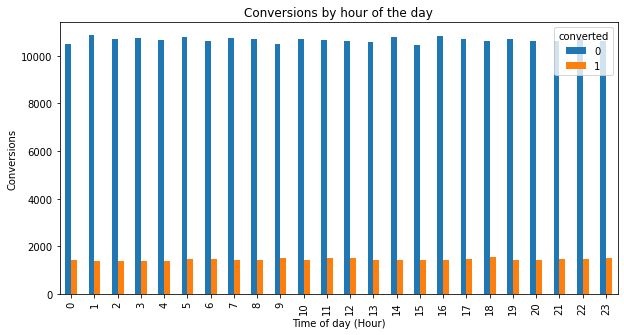

In [128]:
#number of conversions by hour of the day
pd.crosstab(df_merged.time_of_day,df_merged.converted).plot(kind='bar')
plt.xlabel('Time of day (Hour)')
plt.ylabel('Conversions')
plt.title('Conversions by hour of the day');

In [129]:
#how long did the test run
df_merged['date'] = pd.to_datetime(df_merged['date'])
date_range = f'{df_merged.date.dt.date.min()} to {df_merged.date.dt.date.max()}'
date_range

'2017-01-02 to 2017-01-24'

The test ran for approximately 3 weeks in January of 2017.  

The day of the month also doesn't seem to have an effect on the conversion rate. The lower values on the first and last day are probably due to that the test didn't run 24 hours on these days.

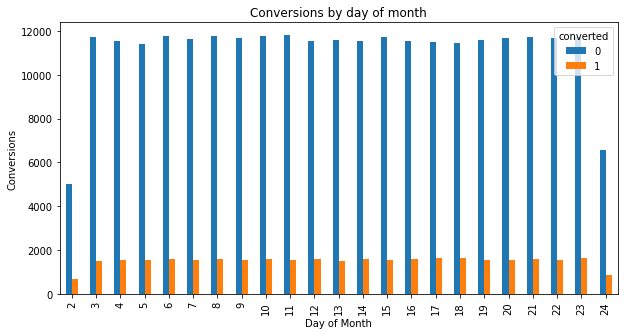

In [130]:
#number of conversions by day of the month
df_merged['day'] = pd.to_datetime(df_merged['timestamp']).dt.day
pd.crosstab(df_merged.day,df_merged.converted).plot(kind='bar')
plt.xlabel('Day of Month')
plt.ylabel('Conversions')
plt.title('Conversions by day of month');

The day of the week also doesn't to be a strong predictor for conversion.

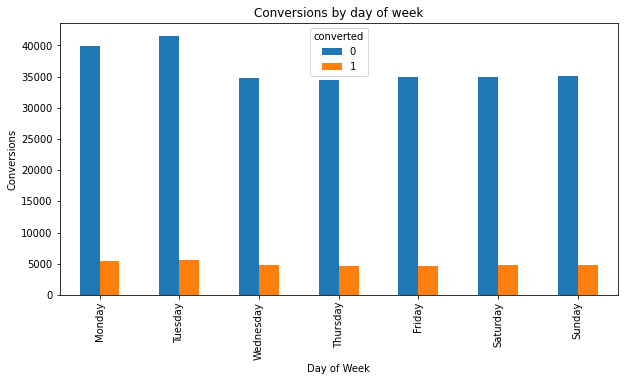

In [131]:
#number of conversions by day of week
pd.crosstab(df_merged.weekday,df_merged.converted).plot(kind='bar')
plt.xticks(list(range(0,7)) , ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Day of Week')
plt.ylabel('Conversions')
plt.title('Conversions by day of week');

<a id='conclusion'></a>
## Conclusion

The new page does not improve conversion rate. On the contrary, it decreases it slightly – the conversion rate for the old page is 12%, while the conversion rate for the new page is 11.89%.  
The country a user comes from does not have a significant effect on the conversion rate, neither by itself nor together with the old or new page.  
It would be better to keep the old page for now and look for other possible ways to increase conversion rate. 

Visual exploration of the effect of date and time on conversion doesn't indicate that either has a strong influence. However, it might be worth it to run the test a little longer than 3 weeks to see if that makes a difference. 

<a id='resources'></a>
### Recources used

- pandas documentation
- stack overflow
- datacamp.com
- https://www.sciencedirect.com/topics/nursing-and-health-professions/logistic-regression-analysis
- https://www.juanshishido.com/logisticcoefficients.html
- https://www.bogotobogo.com/python/scikit-learn/scikit-learn_logistic_regression.php
- https://www.andrewvillazon.com/logistic-regression-python-statsmodels/
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8